# AutoML Image Classification - Model Tests (Edge + Cloud) & Explanations

Contributors: michaelmenzel@

This Colab facilitates test predictions with Cloud AutoML Vision generated models for image classification. The model can be queried on classifications of test images, either in the cloud or offline as exported model.

Parameters needed are as minimal as possible, and you only need to provide:
- Project ID: project where the AutoML model was training.
- Model ID: the identifier of the trained model which can be found in the AutoML UI and API.
- Example Image: a Cloud Storage URI to an example image for test predictions and explanations.

In [19]:
#@title Parameters
!pip install -q --upgrade "pyyaml>=5.2" google-cloud-automl google-cloud-storage saliency

import base64
import json
import os
import tempfile

import matplotlib.pyplot as plt

import tensorflow as tf
import saliency

from google.cloud import automl_v1beta1 as automl, automl as automl_v1, storage

project_id = 'sandbox-michael-menzel' #@param {type:"string"}
model_id = 'ICN7392724759026335744' #@param {type:"string"}
example_image = 'gs://automl-clouds-michael-menzel/1.jpg' #@param {type:"string"}
model_export_path = 'gs://automl-clouds-michael-menzel/models/' #@param {type:"string"}

service_account_name='automl-vision-icn-sa'

In [4]:
#@title Authenticate

#@title Run this code to authenticate & obtain credentials [RUN]
!gcloud config set project $project_id
import googleapiclient.discovery
from google.oauth2 import service_account

from google.colab import auth
auth.authenticate_user()
#user_name = !gcloud config get-value core/account

def get_credentials():
  try:
    return credentials
  except:
    return None

if not get_credentials():
  iam_service = googleapiclient.discovery.build('iam', 'v1', cache_discovery=False)

  # check if service account exists
  service_accounts = iam_service.projects().serviceAccounts().list(
          name=f"projects/{project_id}").execute()
  sa_name = f"{service_account_name}@{project_id}.iam.gserviceaccount.com"

  # create service account if it does not exists
  if not any(a['name'].split('/')[-1] == sa_name for a in service_accounts.get('accounts',[])):
    new_sa = iam_service.projects().serviceAccounts().create(
      name='projects/' + project_id,
      body={
        'accountId': service_account_name,
      }).execute()

    crm_service = googleapiclient.discovery.build("cloudresourcemanager", "v1", cache_discovery=False)
    roles = ['roles/storage.admin',
        'roles/automl.editor',
        'roles/logging.viewer']

    crm_policy = crm_service.projects().getIamPolicy(resource=project_id).execute()
    for role in roles:
      binding = {'role': role, 'members': [f"serviceAccount:{sa_name}"]}
      crm_policy["bindings"].append(binding)
    crm_policy = crm_service.projects().setIamPolicy(
      resource=project_id, body={"policy": crm_policy}).execute()

    print(f"Created service account: {new_sa['name']}")

  keys = iam_service.projects().serviceAccounts().keys().list(
      name=f"projects/{project_id}/serviceAccounts/{sa_name}",
      keyTypes='USER_MANAGED'
  ).execute()
  if 'keys' in keys.keys() and len(keys['keys']):
    for key in keys['keys']:
      iam_service.projects().serviceAccounts().keys().delete(
          name=key['name']
        ).execute()

  key = iam_service.projects().serviceAccounts().keys().create(
      name=f"projects/{project_id}/serviceAccounts/{sa_name}",
      body={'privateKeyType':'TYPE_GOOGLE_CREDENTIALS_FILE'}
    ).execute()

  credentials = service_account.Credentials.from_service_account_info(
      json.loads(base64.decodebytes(key['privateKeyData'].encode())),
      scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )

  print("service account authorized and credentials created")

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

service account authorized and credentials created


In [74]:
#@title Clients & Helpers
automl_client = automl.AutoMlClient(credentials=get_credentials())
prediction_client = automl.PredictionServiceClient(credentials=get_credentials())
gcs_client = storage.Client(project=project_id)

model_full_id = automl_client.model_path(project_id, "us-central1", model_id)

def get_image(gcs_uri):
  _, tf = tempfile.mkstemp()
  with open(tf, 'wb') as df:
    gcs_client.download_blob_to_file(example_image, df)

  with open(tf, 'rb') as df:
    return tf, df.read()

  return None, None

def plot_image(img_path):
  plt.imshow(plt.imread(tf.io.gfile.GFile(img_path, 'rb')))
  plt.axis('off')
  plt.show()

def plot_tensor(img_tensor, cmap=None):
  plt.imshow(img_tensor, cmap=cmap)
  plt.axis('off')
  plt.show()

def plot_tensor_overlay(img_tensor, overlay_tensor, alpha=0.5, cmap=None):
  plt.imshow(img_tensor)
  plt.imshow(overlay_tensor, 
             alpha=((overlay_tensor-overlay_tensor.min())/overlay_tensor.max()), 
             cmap=cmap)
  plt.axis('off')
  plt.show() 

def get_prediction(content, project_id, model_id):
  
  image = automl.Image(image_bytes=content)
  payload = automl.ExamplePayload(image=image)
  params = {"score_threshold": "0.1"}
  request = automl.PredictRequest(name=model_full_id, payload=payload, params=params)

  return prediction_client.predict(request=request)

def predict(gcs_uri, project_id, model_id):
  return get_prediction(tf.io.read_file(example_image).numpy(), project_id, model_id)

def export_model(model_full_id):
  output_config = automl.types.io.ModelExportOutputConfig(
      gcs_destination=automl.types.io.GcsDestination(
          output_uri_prefix=os.path.join(model_export_path, model_id)),
      model_format='tf_saved_model'
    )

  export_request = automl.types.service.ExportModelRequest(name=model_full_id, output_config=output_config)
  export_job = automl_client.export_model(request=export_request)
  export_job.result()
  gcs_destination = os.path.join(
      export_job.metadata.export_model_details.output_info.gcs_output_directory, 
      'saved_model.pb'
    )
  model_file = os.path.join(tempfile.mkdtemp(), 'saved_model.pb')
  with open(model_file, 'wb') as tfd:
    gcs_client.download_blob_to_file(gcs_destination, tfd)

  print('Stored exported model to file:', model_file)
  return os.path.dirname(model_file)

def load_model(model_file):
  tf_model = tf.saved_model.load(model_file, tags=['serve']).signatures['serving_default']
  print('Input Signature:', tf_model.structured_input_signature)
  print('Output Signature:', tf_model.structured_outputs)

  return tf_model

## Test Prediction

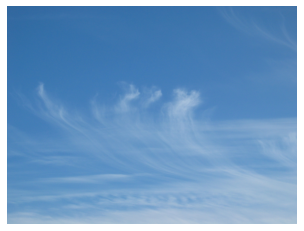

Class: cirrus with confidence: 0.7633397579193115


In [21]:
result = predict(example_image, project_id, model_id)
annotation = result.payload[0]

plot_image(example_image)
print(f"Class: {annotation.display_name} with confidence: {annotation.classification.score}")

## Model Export

In [22]:
model_file = export_model(model_full_id)
local_model = load_model(model_file)

Stored exported model to file: /tmp/tmpuoj0jmbv/saved_model.pb
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Input Signature: ((), {'image_bytes': TensorSpec(shape=(None,), dtype=tf.string, name='image_bytes'), 'key': TensorSpec(shape=(None,), dtype=tf.string, name='key')})
Output Signature: {'scores': <tf.Tensor 'scores:0' shape=(None, 3) dtype=float32>, 'key': <tf.Tensor 'Identity:0' shape=(None,) dtype=string>, 'labels': <tf.Tensor 'Tile:0' shape=(None, 3) dtype=string>}


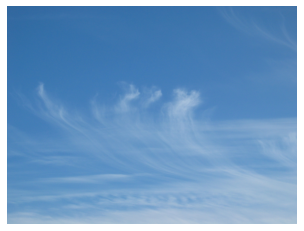

Class: cirrus with confidence: 0.7420836091041565


In [23]:
local_annotation = local_model(key=tf.constant(['test']), image_bytes=tf.expand_dims(tf.io.read_file(example_image), -1))
max_score = tf.reduce_max(local_annotation['scores'], -1)[0]
max_score_arg = tf.argmax(tf.squeeze(local_annotation['scores'])).numpy()
max_label = str(tf.squeeze(local_annotation['labels'])[max_score_arg].numpy(), encoding='utf-8')

plot_image(example_image)
print(f"Class: {max_label} with confidence: {max_score}")

## Saliency (in TF 1)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.


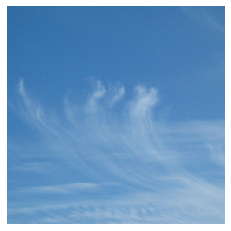

Class: b'cirrus' with confidence: 0.7420836091041565


In [24]:
graph = tf.Graph()
with graph.as_default():
  sess = tf.compat.v1.Session(graph=graph)

  with sess.as_default():
    local_model = tf.compat.v1.saved_model.loader.load(sess, ["serve"], model_file)

    x           = graph.get_tensor_by_name("map/TensorArrayStack/TensorArrayGatherV3:0") #digging into the model's image preprocessing results
    img_inp_var = graph.get_tensor_by_name('Placeholder:0')
    image       = tf.io.read_file(example_image).eval()
    
    neuron_selector = tf.compat.v1.placeholder(tf.int32)
    logitDesc       = graph.get_tensor_by_name('Tile:0')
    logits          = graph.get_tensor_by_name('scores:0')
    prediction      = tf.argmax(logits, 1)
    y               = logits[0][neuron_selector]

    result = sess.run([prediction, logitDesc, logits, x] , feed_dict={img_inp_var: [image]} )

    prediction_class = result[0][0]
    prediction_class_name = result[1][0][prediction_class]
    max_score = result[2][0][prediction_class]
    img_raw = result[3][0]
    img_base = (img_raw + 1) / 2

    plot_tensor(img_base)
    print(f"Class: {prediction_class_name} with confidence: {max_score}")
    
    gradient_saliency = saliency.tf1.GradientSaliency(graph, sess, y, x)
    gs_smoothed_mask = saliency.tf1.VisualizeImageGrayscale(gradient_saliency.GetSmoothedMask(img_raw, feed_dict = {neuron_selector: prediction_class}))

    integrated_gradients = saliency.tf1.IntegratedGradients(graph, sess, y, x)
    ig_smoothed_mask = saliency.tf1.VisualizeImageGrayscale(gradient_saliency.GetSmoothedMask(img_raw, feed_dict = {neuron_selector: prediction_class}))

    xrai_saliency = saliency.tf1.XRAI(graph, sess, y, x)
    xrai_mask = xrai_saliency.GetMask(img_raw, feed_dict={neuron_selector: prediction_class})

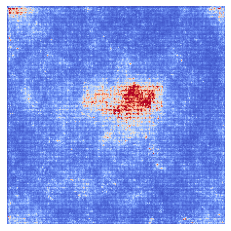

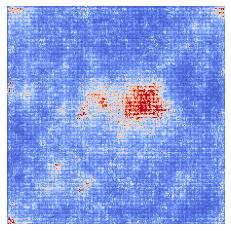

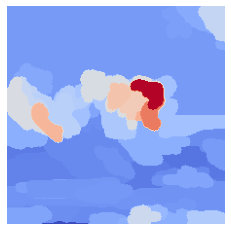

In [29]:
plot_tensor(gs_smoothed_mask, cmap='coolwarm')
plot_tensor(ig_smoothed_mask, cmap='coolwarm')
plot_tensor(xrai_mask, cmap='coolwarm')

1.0


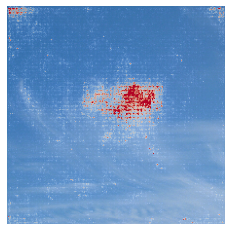

1.0


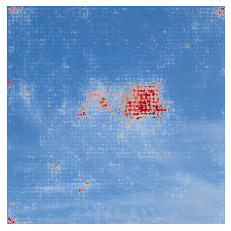

0.0008914886857382953


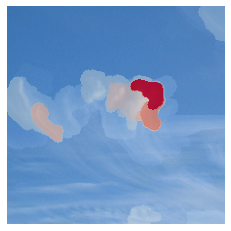

In [73]:
plot_tensor_overlay(img_base, gs_smoothed_mask, cmap='coolwarm')
plot_tensor_overlay(img_base, ig_smoothed_mask, cmap='coolwarm')
plot_tensor_overlay(img_base, xrai_mask, cmap='coolwarm')